<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#data-preparing" data-toc-modified-id="data-preparing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data preparing</a></span><ul class="toc-item"><li><span><a href="#transformers" data-toc-modified-id="transformers-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>transformers</a></span></li><li><span><a href="#train/test-split" data-toc-modified-id="train/test-split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>train/test split</a></span></li></ul></li><li><span><a href="#NN-part" data-toc-modified-id="NN-part-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NN part</a></span><ul class="toc-item"><li><span><a href="#model" data-toc-modified-id="model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>model</a></span></li><li><span><a href="#dataset-class" data-toc-modified-id="dataset-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>dataset class</a></span></li><li><span><a href="#model-classes" data-toc-modified-id="model-classes-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>model classes</a></span></li><li><span><a href="#training-cycle" data-toc-modified-id="training-cycle-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>training cycle</a></span></li><li><span><a href="#validation-score" data-toc-modified-id="validation-score-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>validation score</a></span></li></ul></li><li><span><a href="#test-part" data-toc-modified-id="test-part-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>test part</a></span></li><li><span><a href="#tensorboard" data-toc-modified-id="tensorboard-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>tensorboard</a></span></li></ul></div>

In [1]:
!pip3 install -r requirements.txt

^C


In [2]:
!pip3 freeze > requirements.txt

# imports

In [1]:
import pandas as pd
import numpy as np
import os
import torchmetrics
import time
from tqdm.notebook import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
import torch
import pytorch_lightning
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader, IterableDataset, Dataset
from torchvision import datasets, transforms
import PIL
torch.__version__, pytorch_lightning.__version__

('1.10.0+cu113', '1.5.10')

# data preparing

In [4]:
data_dir = './'
work_dir = './'

In [5]:
labels = pd.read_csv('./train_labels.csv', index_col=0)
labels = labels.to_dict()['label']
labels 

{'train/img_000.png': 1,
 'train/img_001.png': 2,
 'train/img_002.png': 0,
 'train/img_003.png': 0,
 'train/img_004.png': 2,
 'train/img_005.png': 1,
 'train/img_006.png': 2,
 'train/img_007.png': 1,
 'train/img_008.png': 1,
 'train/img_009.png': 1,
 'train/img_010.png': 1,
 'train/img_011.png': 0,
 'train/img_012.png': 2,
 'train/img_013.png': 1,
 'train/img_014.png': 1,
 'train/img_015.png': 0,
 'train/img_016.png': 0,
 'train/img_017.png': 2,
 'train/img_018.png': 0,
 'train/img_019.png': 1,
 'train/img_020.png': 2,
 'train/img_021.png': 0,
 'train/img_022.png': 0,
 'train/img_023.png': 3,
 'train/img_024.png': 2,
 'train/img_025.png': 3,
 'train/img_026.png': 0,
 'train/img_027.png': 2,
 'train/img_028.png': 0,
 'train/img_029.png': 2,
 'train/img_030.png': 2,
 'train/img_031.png': 1,
 'train/img_032.png': 1,
 'train/img_033.png': 2,
 'train/img_034.png': 1,
 'train/img_035.png': 1,
 'train/img_036.png': 0,
 'train/img_037.png': 0,
 'train/img_038.png': 1,
 'train/img_039.png': 2,


In [6]:
# zero class
PIL.Image.open([k for k in labels if labels[k]==0][0])

In [7]:
# first class
PIL.Image.open([k for k in labels if labels[k]==1][0])

In [8]:
# second class
PIL.Image.open([k for k in labels if labels[k]==2][0])

In [9]:
# third class
image = PIL.Image.open([k for k in labels if labels[k]==3][0])
image

In [10]:
image.transpose(PIL.Image.ROTATE_270)

In [11]:
v, class_counts = np.unique([x for x in labels.values()], return_counts=True)
class_counts 

array([86, 92, 86, 46], dtype=int64)

In [12]:
class_weights = 1/(class_counts /sum(class_counts))  
class_weights

array([3.60465116, 3.36956522, 3.60465116, 6.73913043])

## transformers

In [13]:
data_transforms = transforms.Compose([
    transforms.Pad(padding=4, fill=255, padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
data_transforms = transforms.Compose([
    transforms.Pad(padding=4, fill=255, padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [101]:
def load_images(data_path: str,
                labels: dict,
                transformers=None,
                with_augments=True) -> list:
    images = []
    for f in os.listdir(data_path):
        image = PIL.Image.open(data_path + f)
        augments = []
        augments.append(image)
        if with_augments:
            augments.append(image.transpose(PIL.Image.FLIP_LEFT_RIGHT))
            augments.append(image.transpose(PIL.Image.FLIP_TOP_BOTTOM))
            augments.append(image.transpose(PIL.Image.TRANSPOSE))
            augments.append(image.transpose(PIL.Image.ROTATE_90))
            augments.append(image.transpose(PIL.Image.ROTATE_270))
        for augment in augments:
            if transformers:
                augment = transformers(augment)
            else:
                augment = torch.tensor(np.array(augment))
            images.append((augment, labels.get(data_path + f, None)))

    return images

In [102]:
train_images = load_images('train/', labels, transformers=data_transforms)
len(train_images)

1860

In [103]:
targets = [y for x,y in train_images]
len(targets)

1860

## train/test split

In [133]:
train_part, test_part = train_test_split(train_images,
                                         train_size=0.7,
                                         stratify=targets,
                                         random_state=134)
len(train_part), len(test_part)

(1302, 558)

# NN part

In [134]:
BATCH_SIZE = 512
EPOCHS=250

## model

## dataset class

In [135]:
class ImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, claz = self.dataset[index]
        return img, claz


train_dataloader = DataLoader(ImageDataset(train_part),
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)
valid_dataloader = DataLoader(ImageDataset(test_part),
                              num_workers=0,
                              batch_size=BATCH_SIZE)

## model classes

In [136]:
class Net(torch.nn.Module):
    def __init__(self, num_outs: int):
        super().__init__()

        self.relu = torch.nn.LeakyReLU(0.2)

        self.conv1 = torch.nn.Conv2d(in_channels=3,
                                     out_channels=15,
                                     stride=2,
                                     kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(15, 30, stride=2, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = torch.nn.Linear(30, num_outs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.pool1(x))

        x = self.relu(self.pool2(self.conv2(x)))
        x = torch.nn.Flatten()(x)  # flatten all dimensions except batch
        x = self.relu(self.linear1(x))
        return x


net = Net(4)

In [137]:
net.forward(train_part[0][0].unsqueeze(0)).shape

torch.Size([1, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


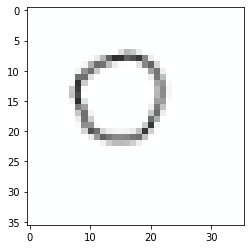

In [138]:
# PIL.Image.fromarray()
def imshow(inp : torch.Tensor, title=None):
    import matplotlib.pyplot as plt
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
imshow(train_part[0][0])

In [152]:
class Model(pytorch_lightning.LightningModule):
    def __init__(self, model: torch.nn.Sequential):
        super().__init__()
        self.model = model
        self.loss = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_h = self.forward(x)
        l = self.loss(y_h, y) 
        self.train_acc(y_h, y) 
        self.log('train_acc',
                 self.train_acc,
                 prog_bar=True,
                 on_step=True,
                 on_epoch=False)
        return l

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_h = self.forward(x)
        l = self.loss(y_h, y)
        self.valid_acc(y_h, y)
        self.log('valid_acc',
                 self.valid_acc,
                 prog_bar=True,
                 on_step=True,
                 on_epoch=True)
        self.log('valid_loss', l.item(), on_step=True, on_epoch=True)
        return l

    def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.model.parameters(),
#                                      lr=1e-2,
#                                      betas=(0.9, 0.999),
#                                      eps=1e-5)
        optimizer = torch.optim.SGD(self.model.parameters(),
                                    momentum=0.7,
                                    lr=5e-2,
                                    weight_decay=0.15,
                                    nesterov=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=85,
                                                    gamma=0.65)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

## training cycle

In [153]:
net = Net(num_outs=4)
early_stop_callback = EarlyStopping(monitor='valid_loss',
                                    min_delta=0.001,
                                    patience=50,
                                    verbose=True,
                                    mode='min')
val_loss_checkpoint = ModelCheckpoint(monitor='valid_loss',
                                      dirpath=work_dir + './models/',
                                      filename='{epoch:02d}-{valid_loss:.4f}',
                                      save_top_k=1,
                                      verbose=True,
                                      mode='min')
model = Model(model=net)
trainer = Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    callbacks=[early_stop_callback, val_loss_checkpoint],
)  # resume_from_checkpoint=work_dir+'./pytorch_models/*' )
trainer.fit(model=model,
            train_dataloader=train_dataloader,
            val_dataloaders=valid_dataloader)
f"best checkpoint path {val_loss_checkpoint.best_model_path}"

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
d:\users\eskander\venv\ml-postflop\lib\site-packages\pytorch_lightning\trainer\trainer.py:736: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Net              | 12.5 K
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)
d:\users\eskander\venv\ml-postflop\lib\site-packages\pyt

Validation sanity check: 0it [00:00, ?it/s]

d:\users\eskander\venv\ml-postflop\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
d:\users\eskander\venv\ml-postflop\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
d:\users\eskander\venv\ml-postflop\lib\site-packages\pytorch_lightning\trainer\data_loading.py:433: UserWa

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_loss improved. New best score: 1.385
Epoch 0, global step 2: valid_loss reached 1.38525 (best 1.38525), saving model to "Z:\Documents\projects\science\merkari\models\epoch=00-valid_loss=1.3853.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.382
Epoch 1, global step 5: valid_loss reached 1.38164 (best 1.38164), saving model to "Z:\Documents\projects\science\merkari\models\epoch=01-valid_loss=1.3816.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.375
Epoch 2, global step 8: valid_loss reached 1.37550 (best 1.37550), saving model to "Z:\Documents\projects\science\merkari\models\epoch=02-valid_loss=1.3755.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.373
Epoch 3, global step 11: valid_loss reached 1.37321 (best 1.37321), saving model to "Z:\Documents\projects\science\merkari\models\epoch=03-valid_loss=1.3732.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.370
Epoch 4, global step 14: valid_loss reached 1.37032 (best 1.37032), saving model to "Z:\Documents\projects\science\merkari\models\epoch=04-valid_loss=1.3703.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.368
Epoch 5, global step 17: valid_loss reached 1.36775 (best 1.36775), saving model to "Z:\Documents\projects\science\merkari\models\epoch=05-valid_loss=1.3677.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.365
Epoch 6, global step 20: valid_loss reached 1.36517 (best 1.36517), saving model to "Z:\Documents\projects\science\merkari\models\epoch=06-valid_loss=1.3652.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.361
Epoch 7, global step 23: valid_loss reached 1.36085 (best 1.36085), saving model to "Z:\Documents\projects\science\merkari\models\epoch=07-valid_loss=1.3608.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.359
Epoch 8, global step 26: valid_loss reached 1.35918 (best 1.35918), saving model to "Z:\Documents\projects\science\merkari\models\epoch=08-valid_loss=1.3592.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.357
Epoch 9, global step 29: valid_loss reached 1.35725 (best 1.35725), saving model to "Z:\Documents\projects\science\merkari\models\epoch=09-valid_loss=1.3572.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.353
Epoch 10, global step 32: valid_loss reached 1.35309 (best 1.35309), saving model to "Z:\Documents\projects\science\merkari\models\epoch=10-valid_loss=1.3531.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.349
Epoch 11, global step 35: valid_loss reached 1.34916 (best 1.34916), saving model to "Z:\Documents\projects\science\merkari\models\epoch=11-valid_loss=1.3492.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 38: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.342
Epoch 13, global step 41: valid_loss reached 1.34182 (best 1.34182), saving model to "Z:\Documents\projects\science\merkari\models\epoch=13-valid_loss=1.3418.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.338
Epoch 14, global step 44: valid_loss reached 1.33817 (best 1.33817), saving model to "Z:\Documents\projects\science\merkari\models\epoch=14-valid_loss=1.3382.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 47: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.333
Epoch 16, global step 50: valid_loss reached 1.33349 (best 1.33349), saving model to "Z:\Documents\projects\science\merkari\models\epoch=16-valid_loss=1.3335.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.013 >= min_delta = 0.001. New best score: 1.321
Epoch 17, global step 53: valid_loss reached 1.32098 (best 1.32098), saving model to "Z:\Documents\projects\science\merkari\models\epoch=17-valid_loss=1.3210.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.313
Epoch 18, global step 56: valid_loss reached 1.31295 (best 1.31295), saving model to "Z:\Documents\projects\science\merkari\models\epoch=18-valid_loss=1.3130.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 59: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 62: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.309
Epoch 21, global step 65: valid_loss reached 1.30950 (best 1.30950), saving model to "Z:\Documents\projects\science\merkari\models\epoch=21-valid_loss=1.3095.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.303
Epoch 22, global step 68: valid_loss reached 1.30287 (best 1.30287), saving model to "Z:\Documents\projects\science\merkari\models\epoch=22-valid_loss=1.3029.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.287
Epoch 23, global step 71: valid_loss reached 1.28674 (best 1.28674), saving model to "Z:\Documents\projects\science\merkari\models\epoch=23-valid_loss=1.2867.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.270
Epoch 24, global step 74: valid_loss reached 1.27046 (best 1.27046), saving model to "Z:\Documents\projects\science\merkari\models\epoch=24-valid_loss=1.2705.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 77: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.017 >= min_delta = 0.001. New best score: 1.253
Epoch 26, global step 80: valid_loss reached 1.25328 (best 1.25328), saving model to "Z:\Documents\projects\science\merkari\models\epoch=26-valid_loss=1.2533.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.029 >= min_delta = 0.001. New best score: 1.224
Epoch 27, global step 83: valid_loss reached 1.22397 (best 1.22397), saving model to "Z:\Documents\projects\science\merkari\models\epoch=27-valid_loss=1.2240.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.018 >= min_delta = 0.001. New best score: 1.206
Epoch 28, global step 86: valid_loss reached 1.20599 (best 1.20599), saving model to "Z:\Documents\projects\science\merkari\models\epoch=28-valid_loss=1.2060.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 89: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.055 >= min_delta = 0.001. New best score: 1.151
Epoch 30, global step 92: valid_loss reached 1.15099 (best 1.15099), saving model to "Z:\Documents\projects\science\merkari\models\epoch=30-valid_loss=1.1510.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.030 >= min_delta = 0.001. New best score: 1.121
Epoch 31, global step 95: valid_loss reached 1.12078 (best 1.12078), saving model to "Z:\Documents\projects\science\merkari\models\epoch=31-valid_loss=1.1208.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.058 >= min_delta = 0.001. New best score: 1.063
Epoch 32, global step 98: valid_loss reached 1.06252 (best 1.06252), saving model to "Z:\Documents\projects\science\merkari\models\epoch=32-valid_loss=1.0625.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 101: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 104: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.026 >= min_delta = 0.001. New best score: 1.036
Epoch 35, global step 107: valid_loss reached 1.03614 (best 1.03614), saving model to "Z:\Documents\projects\science\merkari\models\epoch=35-valid_loss=1.0361.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.993
Epoch 36, global step 110: valid_loss reached 0.99296 (best 0.99296), saving model to "Z:\Documents\projects\science\merkari\models\epoch=36-valid_loss=0.9930.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.044 >= min_delta = 0.001. New best score: 0.949
Epoch 37, global step 113: valid_loss reached 0.94937 (best 0.94937), saving model to "Z:\Documents\projects\science\merkari\models\epoch=37-valid_loss=0.9494.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.937
Epoch 38, global step 116: valid_loss reached 0.93699 (best 0.93699), saving model to "Z:\Documents\projects\science\merkari\models\epoch=38-valid_loss=0.9370.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.898
Epoch 39, global step 119: valid_loss reached 0.89800 (best 0.89800), saving model to "Z:\Documents\projects\science\merkari\models\epoch=39-valid_loss=0.8980.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 122: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.875
Epoch 41, global step 125: valid_loss reached 0.87511 (best 0.87511), saving model to "Z:\Documents\projects\science\merkari\models\epoch=41-valid_loss=0.8751.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.082 >= min_delta = 0.001. New best score: 0.793
Epoch 42, global step 128: valid_loss reached 0.79305 (best 0.79305), saving model to "Z:\Documents\projects\science\merkari\models\epoch=42-valid_loss=0.7931.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.760
Epoch 43, global step 131: valid_loss reached 0.76041 (best 0.76041), saving model to "Z:\Documents\projects\science\merkari\models\epoch=43-valid_loss=0.7604.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 134: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 137: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 140: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 143: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 146: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 149: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 50, global step 152: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 51, global step 155: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 52, global step 158: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.740
Epoch 53, global step 161: valid_loss reached 0.74016 (best 0.74016), saving model to "Z:\Documents\projects\science\merkari\models\epoch=53-valid_loss=0.7402.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 54, global step 164: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.716
Epoch 55, global step 167: valid_loss reached 0.71626 (best 0.71626), saving model to "Z:\Documents\projects\science\merkari\models\epoch=55-valid_loss=0.7163.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.682
Epoch 56, global step 170: valid_loss reached 0.68177 (best 0.68177), saving model to "Z:\Documents\projects\science\merkari\models\epoch=56-valid_loss=0.6818.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.674
Epoch 57, global step 173: valid_loss reached 0.67371 (best 0.67371), saving model to "Z:\Documents\projects\science\merkari\models\epoch=57-valid_loss=0.6737.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.651
Epoch 58, global step 176: valid_loss reached 0.65112 (best 0.65112), saving model to "Z:\Documents\projects\science\merkari\models\epoch=58-valid_loss=0.6511.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 59, global step 179: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 60, global step 182: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 61, global step 185: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 62, global step 188: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 63, global step 191: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 64, global step 194: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 65, global step 197: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 66, global step 200: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 67, global step 203: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 68, global step 206: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 69, global step 209: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 70, global step 212: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 71, global step 215: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 72, global step 218: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.623
Epoch 73, global step 221: valid_loss reached 0.62333 (best 0.62333), saving model to "Z:\Documents\projects\science\merkari\models\epoch=73-valid_loss=0.6233.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 74, global step 224: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 75, global step 227: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 76, global step 230: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.592
Epoch 77, global step 233: valid_loss reached 0.59158 (best 0.59158), saving model to "Z:\Documents\projects\science\merkari\models\epoch=77-valid_loss=0.5916.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 78, global step 236: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 79, global step 239: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 80, global step 242: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.577
Epoch 81, global step 245: valid_loss reached 0.57738 (best 0.57738), saving model to "Z:\Documents\projects\science\merkari\models\epoch=81-valid_loss=0.5774.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.559
Epoch 82, global step 248: valid_loss reached 0.55916 (best 0.55916), saving model to "Z:\Documents\projects\science\merkari\models\epoch=82-valid_loss=0.5592.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 83, global step 251: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 84, global step 254: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 85, global step 257: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 86, global step 260: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 87, global step 263: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 88, global step 266: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 89, global step 269: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 90, global step 272: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 91, global step 275: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 92, global step 278: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 93, global step 281: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 94, global step 284: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 95, global step 287: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 96, global step 290: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 97, global step 293: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 98, global step 296: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 99, global step 299: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.544
Epoch 100, global step 302: valid_loss reached 0.54427 (best 0.54427), saving model to "Z:\Documents\projects\science\merkari\models\epoch=100-valid_loss=0.5443.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.543
Epoch 101, global step 305: valid_loss reached 0.54300 (best 0.54300), saving model to "Z:\Documents\projects\science\merkari\models\epoch=101-valid_loss=0.5430.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.538
Epoch 102, global step 308: valid_loss reached 0.53814 (best 0.53814), saving model to "Z:\Documents\projects\science\merkari\models\epoch=102-valid_loss=0.5381.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 103, global step 311: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 104, global step 314: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 105, global step 317: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 106, global step 320: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 107, global step 323: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 108, global step 326: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.535
Epoch 109, global step 329: valid_loss reached 0.53491 (best 0.53491), saving model to "Z:\Documents\projects\science\merkari\models\epoch=109-valid_loss=0.5349.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.524
Epoch 110, global step 332: valid_loss reached 0.52384 (best 0.52384), saving model to "Z:\Documents\projects\science\merkari\models\epoch=110-valid_loss=0.5238.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 111, global step 335: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 112, global step 338: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 113, global step 341: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 114, global step 344: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 115, global step 347: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 116, global step 350: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 117, global step 353: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 118, global step 356: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 119, global step 359: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 120, global step 362: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 121, global step 365: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.518
Epoch 122, global step 368: valid_loss reached 0.51767 (best 0.51767), saving model to "Z:\Documents\projects\science\merkari\models\epoch=122-valid_loss=0.5177.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 123, global step 371: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 124, global step 374: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 125, global step 377: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 126, global step 380: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 127, global step 383: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 128, global step 386: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 129, global step 389: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 130, global step 392: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.516
Epoch 131, global step 395: valid_loss reached 0.51591 (best 0.51591), saving model to "Z:\Documents\projects\science\merkari\models\epoch=131-valid_loss=0.5159.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 132, global step 398: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 133, global step 401: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 134, global step 404: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 135, global step 407: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 136, global step 410: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.506
Epoch 137, global step 413: valid_loss reached 0.50629 (best 0.50629), saving model to "Z:\Documents\projects\science\merkari\models\epoch=137-valid_loss=0.5063.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 138, global step 416: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 139, global step 419: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 140, global step 422: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 141, global step 425: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 142, global step 428: valid_loss reached 0.50588 (best 0.50588), saving model to "Z:\Documents\projects\science\merkari\models\epoch=142-valid_loss=0.5059.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 143, global step 431: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 144, global step 434: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 145, global step 437: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 146, global step 440: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 147, global step 443: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.494
Epoch 148, global step 446: valid_loss reached 0.49361 (best 0.49361), saving model to "Z:\Documents\projects\science\merkari\models\epoch=148-valid_loss=0.4936.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 149, global step 449: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 150, global step 452: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 151, global step 455: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 152, global step 458: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 153, global step 461: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 154, global step 464: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 155, global step 467: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 156, global step 470: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 157, global step 473: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 158, global step 476: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 159, global step 479: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.490
Epoch 160, global step 482: valid_loss reached 0.49043 (best 0.49043), saving model to "Z:\Documents\projects\science\merkari\models\epoch=160-valid_loss=0.4904.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.489
Epoch 161, global step 485: valid_loss reached 0.48929 (best 0.48929), saving model to "Z:\Documents\projects\science\merkari\models\epoch=161-valid_loss=0.4893.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 162, global step 488: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 163, global step 491: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 164, global step 494: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 165, global step 497: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 166, global step 500: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 167, global step 503: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 168, global step 506: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 169, global step 509: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.488
Epoch 170, global step 512: valid_loss reached 0.48803 (best 0.48803), saving model to "Z:\Documents\projects\science\merkari\models\epoch=170-valid_loss=0.4880.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.484
Epoch 171, global step 515: valid_loss reached 0.48418 (best 0.48418), saving model to "Z:\Documents\projects\science\merkari\models\epoch=171-valid_loss=0.4842.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 172, global step 518: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.480
Epoch 173, global step 521: valid_loss reached 0.47955 (best 0.47955), saving model to "Z:\Documents\projects\science\merkari\models\epoch=173-valid_loss=0.4796.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 174, global step 524: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 175, global step 527: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 176, global step 530: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 177, global step 533: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.478
Epoch 178, global step 536: valid_loss reached 0.47812 (best 0.47812), saving model to "Z:\Documents\projects\science\merkari\models\epoch=178-valid_loss=0.4781.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 179, global step 539: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 180, global step 542: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 181, global step 545: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.474
Epoch 182, global step 548: valid_loss reached 0.47401 (best 0.47401), saving model to "Z:\Documents\projects\science\merkari\models\epoch=182-valid_loss=0.4740.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 183, global step 551: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 184, global step 554: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 185, global step 557: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 186, global step 560: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 187, global step 563: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 188, global step 566: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 189, global step 569: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 190, global step 572: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 191, global step 575: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.472
Epoch 192, global step 578: valid_loss reached 0.47165 (best 0.47165), saving model to "Z:\Documents\projects\science\merkari\models\epoch=192-valid_loss=0.4716.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 193, global step 581: valid_loss reached 0.47104 (best 0.47104), saving model to "Z:\Documents\projects\science\merkari\models\epoch=193-valid_loss=0.4710.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.469
Epoch 194, global step 584: valid_loss reached 0.46868 (best 0.46868), saving model to "Z:\Documents\projects\science\merkari\models\epoch=194-valid_loss=0.4687.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 195, global step 587: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.467
Epoch 196, global step 590: valid_loss reached 0.46737 (best 0.46737), saving model to "Z:\Documents\projects\science\merkari\models\epoch=196-valid_loss=0.4674.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 197, global step 593: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 198, global step 596: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 199, global step 599: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 200, global step 602: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 201, global step 605: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 202, global step 608: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 203, global step 611: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 204, global step 614: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 205, global step 617: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 206, global step 620: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 207, global step 623: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 208, global step 626: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 209, global step 629: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 210, global step 632: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 211, global step 635: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 212, global step 638: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 213, global step 641: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 214, global step 644: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 215, global step 647: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 216, global step 650: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 217, global step 653: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 218, global step 656: valid_loss reached 0.46730 (best 0.46730), saving model to "Z:\Documents\projects\science\merkari\models\epoch=218-valid_loss=0.4673.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 219, global step 659: valid_loss reached 0.46720 (best 0.46720), saving model to "Z:\Documents\projects\science\merkari\models\epoch=219-valid_loss=0.4672.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 220, global step 662: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 221, global step 665: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 222, global step 668: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 223, global step 671: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 224, global step 674: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 225, global step 677: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 226, global step 680: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 227, global step 683: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 228, global step 686: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 229, global step 689: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 230, global step 692: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 231, global step 695: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 232, global step 698: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 233, global step 701: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 234, global step 704: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 235, global step 707: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 236, global step 710: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 237, global step 713: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 238, global step 716: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 239, global step 719: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 240, global step 722: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 241, global step 725: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 242, global step 728: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 243, global step 731: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 244, global step 734: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 245, global step 737: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 50 records. Best score: 0.467. Signaling Trainer to stop.
Epoch 246, global step 740: valid_loss was not in top 1


'best checkpoint path Z:\\Documents\\projects\\science\\merkari\\models\\epoch=219-valid_loss=0.4672.ckpt'

## validation score

In [154]:
model.load_state_dict(torch.load(val_loss_checkpoint.best_model_path)['state_dict'])
model = model.cuda()

In [155]:
with torch.no_grad():
    y_tests = []
    y_test_preds = []
    for x_test, y_test in tqdm(valid_dataloader.dataset):
        y_tests.append(y_test)
        y_test_preds.append(
            model.forward(x_test.cuda().unsqueeze(0)).cpu().numpy())

# validation accuracy
accuracy_score(
    y_tests,
    np.argmax(y_test_preds, axis=2).ravel(),
)

  0%|          | 0/558 [00:00<?, ?it/s]

0.9139784946236559

In [156]:
print(classification_report(
    y_tests,
    np.argmax(y_test_preds, axis=2).ravel(),))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       155
           1       0.96      0.90      0.93       165
           2       0.91      0.95      0.93       155
           3       0.84      0.87      0.85        83

    accuracy                           0.91       558
   macro avg       0.91      0.91      0.91       558
weighted avg       0.92      0.91      0.91       558




# test part

I'm guessing, here you can put your dataset as **data_path** argument for **load_test_images** function.


In [157]:
def load_test_images(data_path: str,
                     transformers=None,
                     with_augments=True) -> list:
    images = []
    for f in os.listdir(data_path):
        image = PIL.Image.open(data_path + f)
        augments = []
        augments.append(image)
        if with_augments:
            augments.append(image.transpose(PIL.Image.FLIP_LEFT_RIGHT))
            augments.append(image.transpose(PIL.Image.FLIP_TOP_BOTTOM))
            augments.append(image.transpose(PIL.Image.TRANSPOSE))


#             augments.append(image.transpose(PIL.Image.ROTATE_90))
#             augments.append(image.transpose(PIL.Image.ROTATE_270))
        for augment in augments:
            if transformers:
                augment = transformers(augment)
            else:
                augment = torch.tensor(np.array(augment))
            images.append((augment, data_path + f))

    return images

In [158]:

test_images = load_test_images('test/',
                               transformers=data_transforms,
                               with_augments=False)
len(test_images)

40

In [159]:
test_result_dict = list()
with torch.no_grad():
    for ti, name in test_images:
        test_result_dict.append((name,  torch.argmax(model.forward(ti.cuda().unsqueeze(0)), dim=1).item()))
test_result_dict

[('test/img_000.png', 3),
 ('test/img_001.png', 2),
 ('test/img_002.png', 3),
 ('test/img_003.png', 1),
 ('test/img_004.png', 3),
 ('test/img_005.png', 0),
 ('test/img_006.png', 2),
 ('test/img_007.png', 2),
 ('test/img_008.png', 1),
 ('test/img_009.png', 0),
 ('test/img_010.png', 2),
 ('test/img_011.png', 2),
 ('test/img_012.png', 0),
 ('test/img_013.png', 3),
 ('test/img_014.png', 1),
 ('test/img_015.png', 2),
 ('test/img_016.png', 3),
 ('test/img_017.png', 0),
 ('test/img_018.png', 1),
 ('test/img_019.png', 3),
 ('test/img_020.png', 1),
 ('test/img_021.png', 3),
 ('test/img_022.png', 0),
 ('test/img_023.png', 2),
 ('test/img_024.png', 2),
 ('test/img_025.png', 3),
 ('test/img_026.png', 0),
 ('test/img_027.png', 3),
 ('test/img_028.png', 3),
 ('test/img_029.png', 2),
 ('test/img_030.png', 0),
 ('test/img_031.png', 0),
 ('test/img_032.png', 3),
 ('test/img_033.png', 2),
 ('test/img_034.png', 0),
 ('test/img_035.png', 1),
 ('test/img_036.png', 0),
 ('test/img_037.png', 1),
 ('test/img_

In [160]:
test_result = pd.DataFrame(data=test_result_dict, columns=['file_path', 'label'])
test_result.to_csv('test_result.csv', index=False, header=True)
test_result

,file_path,label
0,test/img_000.png,3
1,test/img_001.png,2
2,test/img_002.png,3
3,test/img_003.png,1
4,test/img_004.png,3
5,test/img_005.png,0
6,test/img_006.png,2
7,test/img_007.png,2
8,test/img_008.png,1
9,test/img_009.png,0


# tensorboard

In [35]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/  --port=8002


Reusing TensorBoard on port 8002 (pid 27132), started 1:24:42 ago. (Use '!kill 27132' to kill it.)